In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

# Load the datasets into DataFrames 
df = pd.read_csv('updated_file.csv')
source1_df = pd.read_csv('death-rates-from-mental-and-substance-disorders-by-age-who.csv')
source2_df = pd.read_csv('psychiatrists-working-in-the-mental-health-sector.csv')
#source3_df = pd.read_csv('psychiatrists-working-in-the-mental-health-sector.csv')

# Merge the DataFrames based on both 'Country' and 'Year' columns
merged_df = pd.merge(df, source1_df, on=['Entity', 'Year'], how='inner')
merged1_df = pd.merge(merged_df, source2_df, on=['Entity', 'Year'], how='inner')
#merged2_df = pd.merge(merged1_df, source3_df, on=['Entity', 'Year'], how='inner')
# Drop rows where GDP column contains NaN values
data = merged1_df.dropna(subset=['GDP per capita, PPP (constant 2017 international $)', 
                                             'Death rate per 100,000 people - Cause: Mental and substance use disorders - Sex: Both sexes - Age_group: ALLAges'])  # Replace 'specific_column' with the actual column name
# Save the filtered data to a new file
data.to_csv('mental_health_data.csv', index=False)


C:\Users\Niloo\AppData\Local\Temp\ipykernel_14784\1707096113.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Code_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged1_df = pd.merge(merged_df, source2_df, on=['Entity', 'Year'], how='inner')


Cross-Validation RMSE Scores: [ 3.20537207  9.27167103 10.11958124  6.92670751  5.48148092]
Mean RMSE: 7.0009625541095275
Standard Deviation of RMSE: 2.5140702005144386


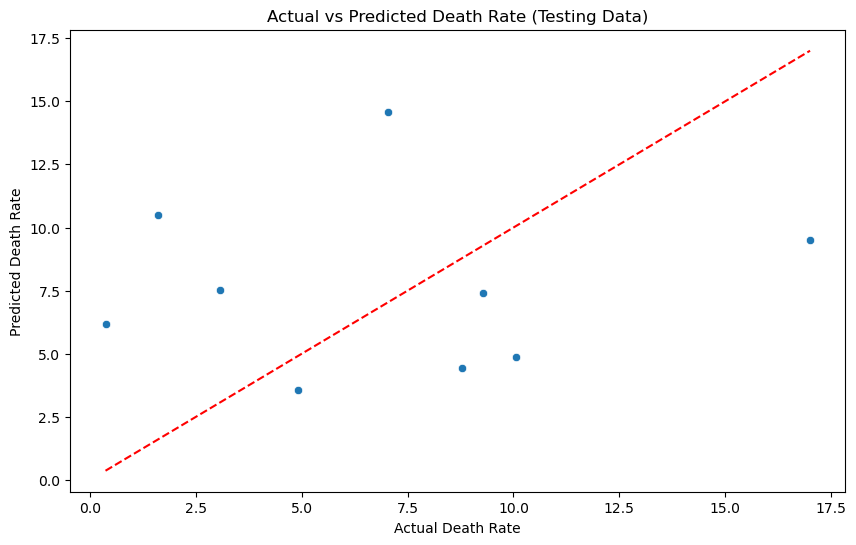

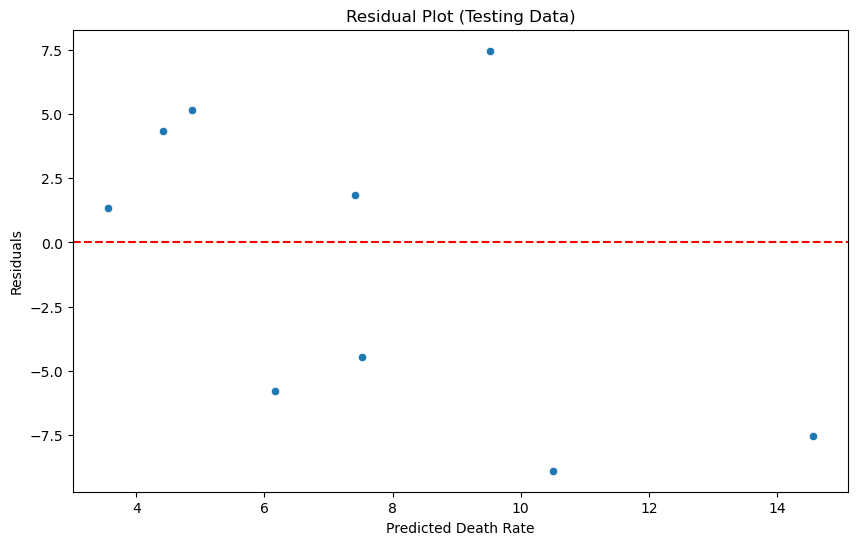

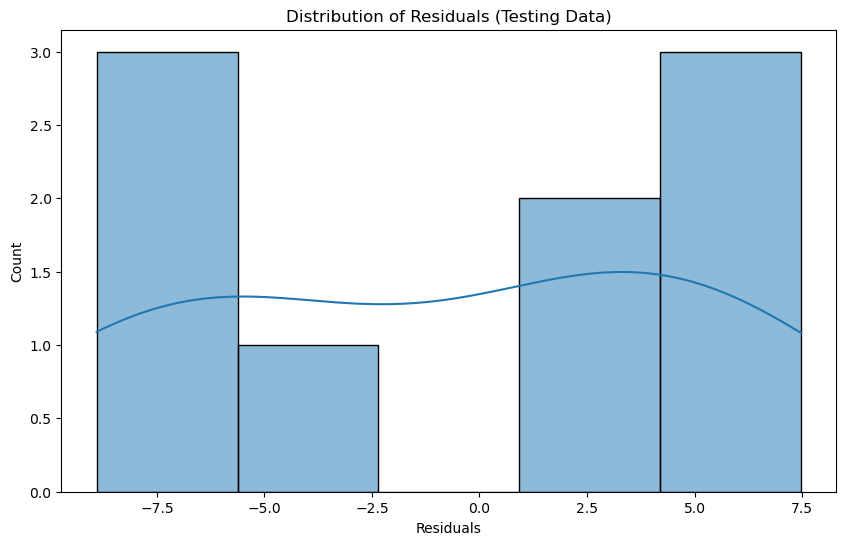

In [5]:
# Define the features (X) and the target (y)
X = data[['GDP per capita, PPP (constant 2017 international $)', 'total_mental_disorders', 'Indicator:Psychiatrists working in mental health sector (per 100 000 population)']]
y = data['Death rate per 100,000 people - Cause: Mental and substance use disorders - Sex: Both sexes - Age_group: ALLAges']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Choose a model (e.g., Linear Regression)
model = LinearRegression()

# Define the k-fold cross-validation procedure
k = 5
kf = KFold(n_splits=k, random_state=42, shuffle=True)

# Use cross_val_score to evaluate the model with cross-validation on training data
mse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE scorer
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mse_scorer)

# Print the cross-validation scores
print(f'Cross-Validation RMSE Scores: {cv_scores}')
print(f'Mean RMSE: {np.mean(cv_scores)}')
print(f'Standard Deviation of RMSE: {np.std(cv_scores)}')

# Fit the model on the training dataset
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Plot actual vs predicted values for testing data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Death Rate')
plt.ylabel('Predicted Death Rate')
plt.title('Actual vs Predicted Death Rate (Testing Data)')
plt.show()

# Calculate residuals on testing data
residuals = y_test - y_pred

# Residual plot for testing data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Death Rate')
plt.ylabel('Residuals')
plt.title('Residual Plot (Testing Data)')
plt.show()

# Distribution of Errors (residuals) on testing data
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals (Testing Data)')
plt.show()


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define a corrected grid of hyperparameters to search
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Reasonable range of estimators
    'max_features': ['sqrt', 'log2', None],  # Valid options for RandomForestRegressor
    'max_depth': [None, 10, 20],  # Use a smaller range of depths
    'min_samples_split': [2, 5, 10],  # Typical values for splitting
    'min_samples_leaf': [1, 2, 4]  # Reasonable leaf sizes
}

# Perform RandomizedSearchCV with error_score='raise' to debug
random_search_rf = RandomizedSearchCV(
    rf, 
    param_grid_rf, 
    cv=kf, 
    n_iter=50, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=42,
    error_score='raise'  # Raise errors for failed fits
)

try:
    random_search_rf.fit(X_train, y_train)
    best_params_rf = random_search_rf.best_params_
    print(f'Best parameters for Random Forest: {best_params_rf}')

    # Train the best Random Forest model
    best_rf = RandomForestRegressor(**best_params_rf, random_state=42)
    best_rf.fit(X_train, y_train)

    # Make predictions and evaluate the Random Forest model
    y_pred_rf = best_rf.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
    r2_rf = best_rf.score(X_test, y_test)

    print(f'Random Forest - Mean Squared Error: {mse_rf}')
    print(f'Random Forest - Root Mean Squared Error: {rmse_rf}')
    print(f'Random Forest - R-squared: {r2_rf}')

    # Cross-validation for the best Random Forest model
    cv_scores_rf = cross_val_score(best_rf, X, y, cv=kf, scoring=make_scorer(mean_squared_error, squared=False))

    # Print the cross-validation scores for Random Forest
    print(f'Random Forest - Cross-Validation RMSE Scores: {cv_scores_rf}')
    print(f'Random Forest - Mean RMSE: {np.mean(cv_scores_rf)}')
    print(f'Random Forest - Standard Deviation of RMSE: {np.std(cv_scores_rf)}')

except Exception as e:
    print(f'Error during model training: {e}')


Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
Random Forest - Mean Squared Error: 27.003011399836762
Random Forest - Root Mean Squared Error: 5.19644218671167
Random Forest - R-squared: -0.15479796108061494
Random Forest - Cross-Validation RMSE Scores: [5.704489   2.92192537 3.31966832 8.99978435 5.5138628 ]
Random Forest - Mean RMSE: 5.2919459693701985
Random Forest - Standard Deviation of RMSE: 2.1667663008591056


In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model
gbr = GradientBoostingRegressor(random_state=42)

# Define the grid of hyperparameters to search
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gbr.fit(X_train, y_train)

# Get the best parameters
best_params_gbr = grid_search_gbr.best_params_
print(f'Best parameters for Gradient Boosting: {best_params_gbr}')

# Train the Gradient Boosting model with the best parameters
best_gbr = GradientBoostingRegressor(**best_params_gbr, random_state=42)
best_gbr.fit(X_train, y_train)

# Evaluate the Gradient Boosting model
y_pred_gbr = best_gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
r2_gbr = best_gbr.score(X_test, y_test)

print(f'Gradient Boosting - Mean Squared Error: {mse_gbr}')
print(f'Gradient Boosting - Root Mean Squared Error: {rmse_gbr}')
print(f'Gradient Boosting - R-squared: {r2_gbr}')

# Define the k-fold cross-validation procedure
k = 5  # Number of folds
kf = KFold(n_splits=k, random_state=42, shuffle=True)

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Use cross_val_score to evaluate the model with cross-validation
mse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE scorer
cv_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

# Print the cross-validation RMSE Scores
print(f'Cross-Validation RMSE Scores: {cv_scores}')

# Calculate Mean RMSE and Standard Deviation of RMSE
mean_rmse = np.mean(cv_scores)
std_rmse = np.std(cv_scores)

print(f'Mean RMSE: {mean_rmse}')
print(f'Standard Deviation of RMSE: {std_rmse}')


Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Gradient Boosting - Mean Squared Error: 18.954213299492906
Gradient Boosting - Root Mean Squared Error: 4.353643680814142
Gradient Boosting - R-squared: 0.1894131158914445
Cross-Validation RMSE Scores: [5.45270196 4.13263652 4.26675892 8.3995264  7.05867102]
Mean RMSE: 5.8620589630570645
Standard Deviation of RMSE: 1.6476697961009514


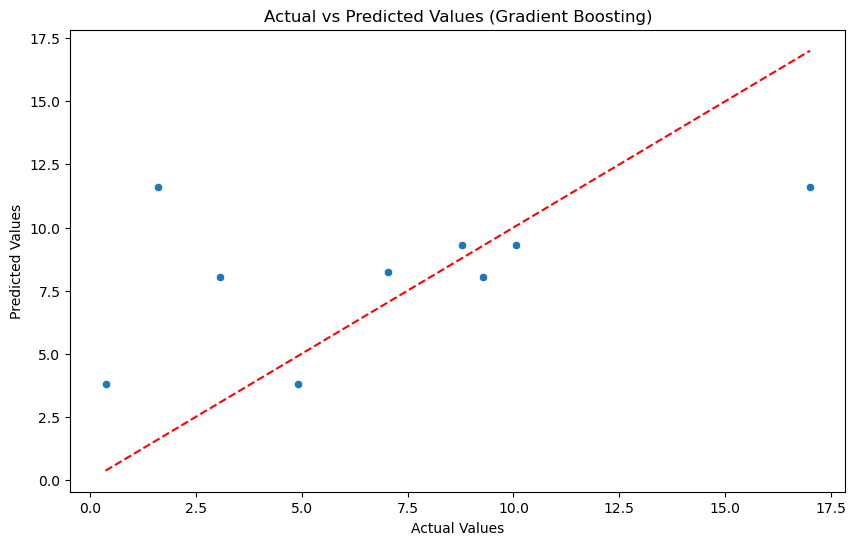

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_gbr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Gradient Boosting)')
plt.savefig('Tot1')
plt.show()


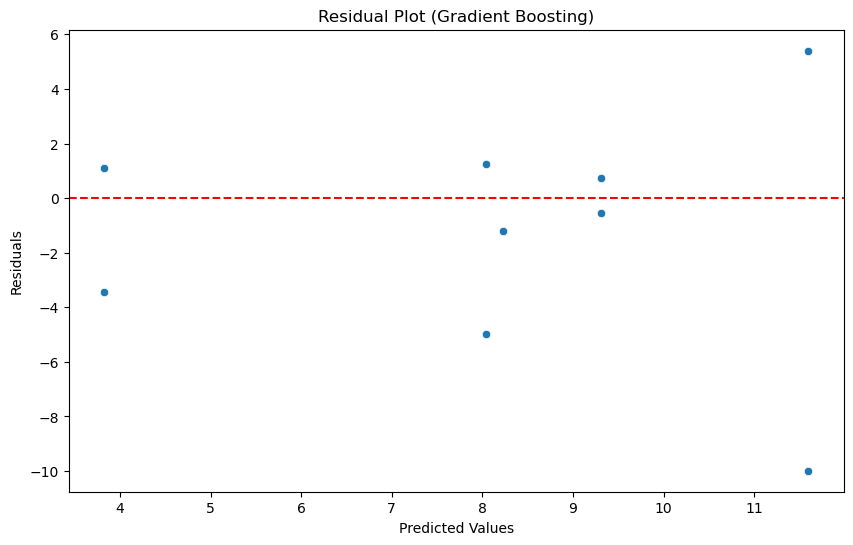

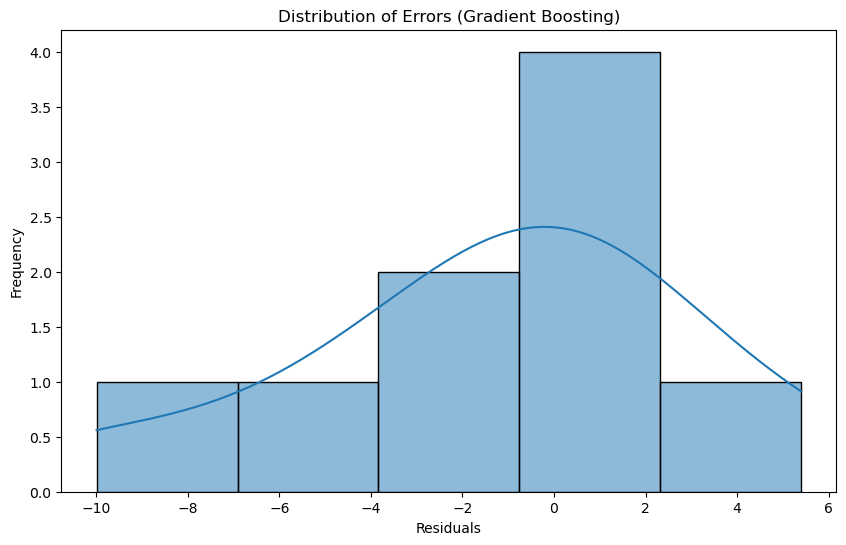

In [17]:
# Calculate residuals
residuals = y_test - y_pred_gbr

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_gbr, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Gradient Boosting)')
plt.savefig('Tot2')
plt.show()
# Plot distribution of errors (residuals)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Errors (Gradient Boosting)')
plt.savefig('Tot3')
plt.show()
